# Flower Images Classification

This project will use deep learning and transfer learning techniques to build a flower image classifier with 14 categories. The goal is to create a reliable model that can correctly identify different flower types using pre-trained CNN models and PyTorch. 

The [dataset](https://www.kaggle.com/datasets/marquis03/flower-classification?select=val) used for training and testing includes 13,618 images for training and 98 for validation, covering flower types such as 
* carnations, 
* irises, 
* roses, 
* tulips, 
* black-eyed susans, 
* water lilies, 
* calendula, 
* sunflowers, 
* dandelions, 
* California poppies, 
* astilbe, 
* bellflowers, 
* coreopsis, and 
* common daisies. 

The total dataset size is 202MB.

In [ ]:
# Import Libraries
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from torchvision import datasets, transforms
import torchvision
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from tqdm import tqdm
import time

import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Loading & Transformation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load and transform data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


images_folder = "/content/drive/MyDrive/Image_Datasets/flower_images"

dataset = datasets.ImageFolder(root=images_folder, transform=transform)
len(dataset)

13642

In [ ]:
# Define number of classes
num_classes = len(dataset.classes)

class_names = dataset.classes
class_names

['astilbe',
 'bellflower',
 'black_eyed_susan',
 'calendula',
 'california_poppy',
 'carnation',
 'common_daisy',
 'coreopsis',
 'dandelion',
 'iris',
 'rose',
 'sunflower',
 'tulip',
 'water_lily']

In [ ]:
# Get all the class indices from dataset
targets = dataset.targets

# Map class index to class name
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Count frequency of image classes
counts = Counter(targets)

# Print count of image classes
for idx, count in counts.items():
    print(f"{idx_to_class[idx]}: {count} images")

astilbe: 726 images
bellflower: 872 images
black_eyed_susan: 986 images
calendula: 1011 images
california_poppy: 1021 images
carnation: 924 images
common_daisy: 978 images
coreopsis: 1035 images
dandelion: 1038 images
iris: 1041 images
rose: 986 images
sunflower: 1013 images
tulip: 1034 images
water_lily: 977 images


In [ ]:
# Split data into train and val sets

# Initialize stratified splitter
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get indices for stratified train/val split
for train_idx, val_idx in splitter.split(X=targets, y=targets):
    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)}")


Train: 10913 | Val: 2729


In [ ]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


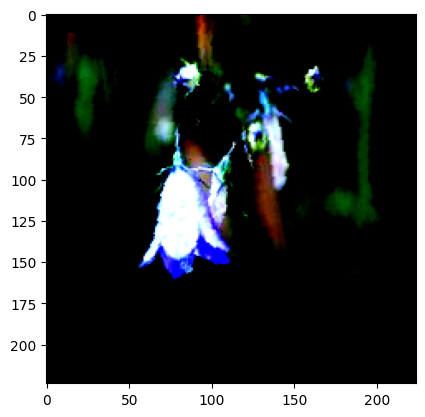

In [ ]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

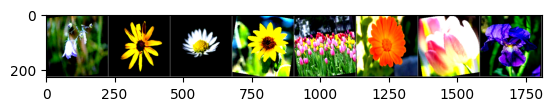

In [ ]:
def imgshow(img):
  img = img /2 + 0.5 # Unnormalize the image
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# Show images
imgshow(torchvision.utils.make_grid(images[:8]))

In [ ]:
# Training Function with time tracking and progress bar
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, start_epoch=0):
    total_start = time.time()
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(start_epoch, epochs + 1):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        # Use tqdm for progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)

        for batch, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(output, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            # Update progress bar description
            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = (train_correct / train_total) * 100
        val_loss, val_acc = validate(model, val_loader, criterion)

        # Append metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        epoch_time = time.time() - epoch_start
        mins, secs = divmod(epoch_time, 60)

        print(f"\nEpoch {epoch}/{epochs} finished in {int(mins)}m {int(secs)}s")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    total_time = time.time() - total_start
    total_mins, total_secs = divmod(total_time, 60)
    print(f"\nTotal training time: {int(total_mins)}m {int(total_secs)}s")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    total, correct, val_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = (correct / total)*100
    return val_loss / len(val_loader), accuracy


# Evaluation function
def evaluate(model, test_loader, criterion, device='cpu'):
    model.eval()
    total, correct, val_loss = 0, 0, 0.0
    all_preds, all_labels = [], []  # For printing confusion_matrix and classification_report

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = (correct / total)*100
    print(f"Test Loss: {val_loss / len(test_loader):.4f}, Test Acc: {accuracy:.2f}%")
    return all_preds, all_labels

## Transfer Learning with EfficientNet

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

        # Freeze all pre-trained layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace the classifier
        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Instantiate the model, loss function and optimizer
model = EfficientNetClassifier(num_classes=num_classes, dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 138MB/s]


In [ ]:
train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 0/10 finished in 2m 40s
Train Loss: 0.5387, Train Acc: 83.77%
Val Loss: 0.4574, Val Acc: 87.28%



Epoch 1/10 finished in 1m 29s
Train Loss: 0.5069, Train Acc: 84.47%
Val Loss: 0.4263, Val Acc: 87.17%



Epoch 2/10 finished in 1m 29s
Train Loss: 0.4887, Train Acc: 84.64%
Val Loss: 0.4044, Val Acc: 88.13%



Epoch 3/10 finished in 1m 28s
Train Loss: 0.4688, Train Acc: 85.05%
Val Loss: 0.3995, Val Acc: 87.98%



Epoch 4/10 finished in 1m 29s
Train Loss: 0.4715, Train Acc: 84.98%
Val Loss: 0.3609, Val Acc: 89.19%



Epoch 5/10 finished in 1m 32s
Train Loss: 0.4634, Train Acc: 85.35%
Val Loss: 0.3717, Val Acc: 88.75%



Epoch 6/10 finished in 1m 29s
Train Loss: 0.4528, Train Acc: 85.82%
Val Loss: 0.3789, Val Acc: 88.27%



Epoch 7/10 finished in 1m 29s
Train Loss: 0.4411, Train Acc: 85.85%
Val Loss: 0.3449, Val Acc: 89.56%



Epoch 8/10 finished in 1m 30s
Train Loss: 0.4472, Train Acc: 85.97%
Val Loss: 0.3514, Val Acc: 89.56%



Epoch 9/10 finished in 1m 28s
Train Loss: 0.4509, Train Acc: 85.55%
Val Loss: 0.3502, Val Acc: 89.63%



Epoch 10/10 finished in 1m 29s
Train Loss: 0.4350, Train Acc: 86.14%
Val Loss: 0.3438, Val Acc: 89.85%

Total training time: 17m 39s


These outputs show the training results for the EfficientNet model. The Train Loss and Val Loss generally decrease, and Train Acc and Val Acc generally increase over the epochs.

By Epoch 10, the validation accuracy reached 89.85%.

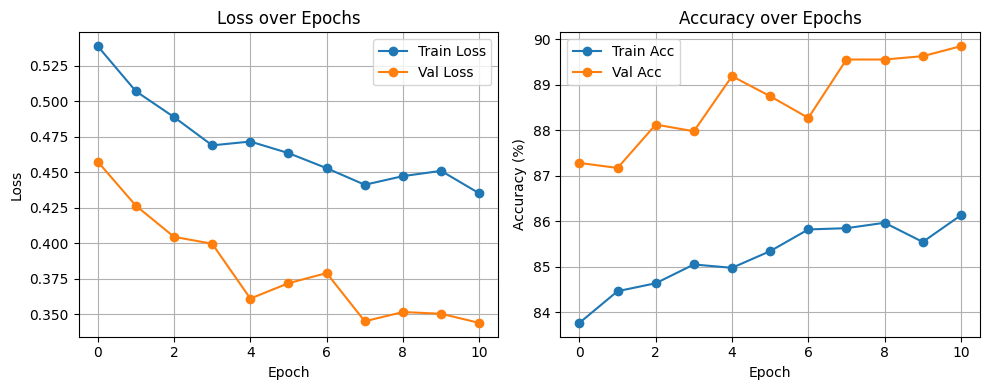

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', marker='o')
plt.plot(val_accs, label='Val Acc', marker='o')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import os

def save_checkpoint(model, optimizer, epoch, path):
    """
    Saves model and optimizer state to the given path.

    Args:
        model (nn.Module): The model to save.
        optimizer (torch.optim.Optimizer): The optimizer.
        epoch (int): The last completed epoch.
        path (str): Full file path to save the checkpoint
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"✅ Checkpoint saved to {path}")


In [ ]:
# Save model after training
save_path = '/content/drive/MyDrive/Models/efficientnet_flower_classifier_v1.pth'

save_checkpoint(model, optimizer, epoch=10, path=save_path)


✅ Checkpoint saved to /content/drive/MyDrive/Models/efficientnet_flower_classifier_v1.pth


## Transfer Learning with ResNet34

In [ ]:
from torchvision.models import resnet34, ResNet34_Weights

class ResNetClassifier(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = resnet34(weights=ResNet34_Weights.DEFAULT)

        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze Layer 4 for fine-tuning
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the fully connected (fc) layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Instantiate the model, loss function and optimizer
model = ResNetClassifier(num_classes=num_classes, dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 189MB/s]


In [ ]:
train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 0/10 finished in 1m 33s
Train Loss: 0.7100, Train Acc: 79.16%
Val Loss: 0.4731, Val Acc: 85.60%



Epoch 1/10 finished in 1m 31s
Train Loss: 0.3949, Train Acc: 88.60%
Val Loss: 0.3321, Val Acc: 90.03%



Epoch 2/10 finished in 1m 30s
Train Loss: 0.2996, Train Acc: 91.01%
Val Loss: 0.2900, Val Acc: 91.10%



Epoch 3/10 finished in 1m 29s
Train Loss: 0.2883, Train Acc: 91.82%
Val Loss: 0.2353, Val Acc: 92.67%



Epoch 4/10 finished in 1m 31s
Train Loss: 0.2343, Train Acc: 93.16%
Val Loss: 0.2491, Val Acc: 92.09%



Epoch 5/10 finished in 1m 29s
Train Loss: 0.1878, Train Acc: 94.54%
Val Loss: 0.2622, Val Acc: 91.87%



Epoch 6/10 finished in 1m 30s
Train Loss: 0.1744, Train Acc: 94.61%
Val Loss: 0.2611, Val Acc: 92.63%



Epoch 7/10 finished in 1m 40s
Train Loss: 0.1641, Train Acc: 95.03%
Val Loss: 0.2561, Val Acc: 92.82%



Epoch 8/10 finished in 1m 32s
Train Loss: 0.1198, Train Acc: 96.13%
Val Loss: 0.3062, Val Acc: 91.83%



Epoch 9/10 finished in 1m 33s
Train Loss: 0.2070, Train Acc: 94.51%
Val Loss: 0.2792, Val Acc: 92.93%



Epoch 10/10 finished in 1m 32s
Train Loss: 0.1328, Train Acc: 96.11%
Val Loss: 0.2191, Val Acc: 93.92%

Total training time: 16m 54s


Validation accuracy for ResNet34 reached an impressive 93.92%. This is higher than EfficientNet's result.

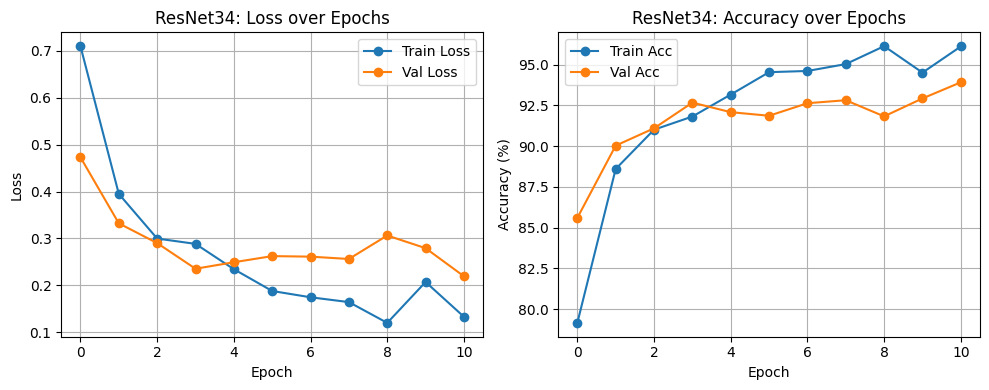

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title("ResNet34: Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', marker='o')
plt.plot(val_accs, label='Val Acc', marker='o')
plt.title("ResNet34: Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Save model after training
save_path = '/content/drive/MyDrive/Models/resnet_flower_classifier_v1.pth'

save_checkpoint(model, optimizer, epoch=10, path=save_path)


✅ Checkpoint saved to /content/drive/MyDrive/Models/resnet_flower_classifier_v1.pth


## Transfer Learning with DenseNet121

In [ ]:
from torchvision.models import densenet121, DenseNet121_Weights

class DenseNetClassifier(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = densenet121(weights=DenseNet121_Weights.DEFAULT)

        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze the classifier layer (can be adjusted to earlier layers if needed)
        for param in self.model.features.denseblock4.parameters():
            param.requires_grad = True

        # Replace the classifier
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Instantiate the model, loss function and optimizer
model = DenseNetClassifier(num_classes=num_classes, dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 146MB/s]


In [ ]:
train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 0/10 finished in 1m 41s
Train Loss: 0.4346, Train Acc: 86.87%
Val Loss: 0.2185, Val Acc: 92.89%



Epoch 1/10 finished in 1m 41s
Train Loss: 0.2183, Train Acc: 93.16%
Val Loss: 0.2261, Val Acc: 92.82%



Epoch 2/10 finished in 1m 38s
Train Loss: 0.1689, Train Acc: 94.47%
Val Loss: 0.2070, Val Acc: 93.40%



Epoch 3/10 finished in 1m 38s
Train Loss: 0.1520, Train Acc: 94.97%
Val Loss: 0.2036, Val Acc: 94.06%



Epoch 4/10 finished in 1m 38s
Train Loss: 0.1209, Train Acc: 95.98%
Val Loss: 0.2033, Val Acc: 94.28%



Epoch 5/10 finished in 1m 38s
Train Loss: 0.1008, Train Acc: 96.40%
Val Loss: 0.1875, Val Acc: 94.65%



Epoch 6/10 finished in 1m 38s
Train Loss: 0.0967, Train Acc: 96.80%
Val Loss: 0.2222, Val Acc: 93.44%



Epoch 7/10 finished in 1m 39s
Train Loss: 0.0900, Train Acc: 97.06%
Val Loss: 0.1814, Val Acc: 94.61%



Epoch 8/10 finished in 1m 38s
Train Loss: 0.0712, Train Acc: 97.57%
Val Loss: 0.1744, Val Acc: 95.49%



Epoch 9/10 finished in 1m 39s
Train Loss: 0.0659, Train Acc: 97.73%
Val Loss: 0.1932, Val Acc: 94.69%



Epoch 10/10 finished in 1m 38s
Train Loss: 0.0588, Train Acc: 98.08%
Val Loss: 0.1724, Val Acc: 95.46%

Total training time: 18m 9s


The DenseNet121 model achieved the highest validation accuracy of all three models, hitting 95.46% by Epoch 10! The training loss dropped significantly, showing strong learning.

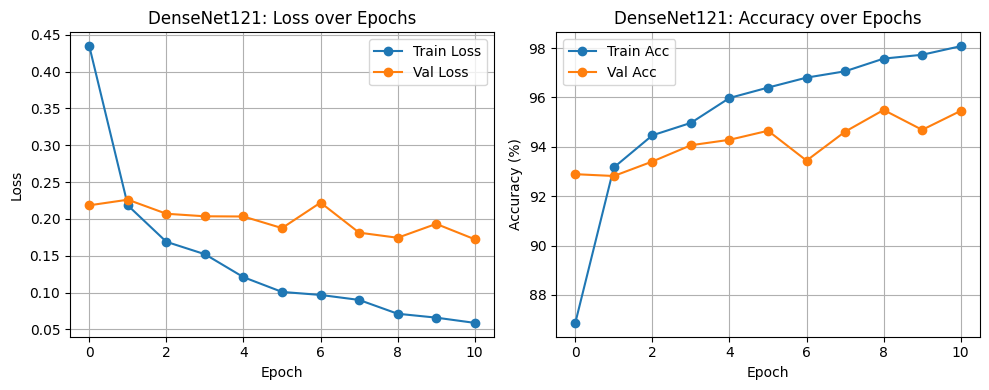

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title("DenseNet121: Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', marker='o')
plt.plot(val_accs, label='Val Acc', marker='o')
plt.title("DenseNet121: Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Save model after training
save_path = '/content/drive/MyDrive/Models/densenet_flower_classifier_v1.pth'

save_checkpoint(model, optimizer, epoch=10, path=save_path)


✅ Checkpoint saved to /content/drive/MyDrive/Models/densenet_flower_classifier_v1.pth


## Model Evaluation on Test Data

In [ ]:
def load_checkpoint(model, optimizer=None, path='', device='cpu'):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("✅ Optimizer state loaded.")

    print(f"✅ Model loaded from {path}")
    return checkpoint.get('epoch', 0) + 1


In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Keep size consistent with training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

images_folder = "/content/drive/MyDrive/Image_Datasets/flower_images_test"

test_dataset = datasets.ImageFolder(root=images_folder, transform=test_transform)
len(test_dataset)

98

In [ ]:
class_names = test_dataset.classes

In [ ]:
# Get all the class indices from dataset
targets = test_dataset.targets

# Map class index to class name
class_to_idx = test_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Count frequency for each class
counts = Counter(targets)

# Print image count for each class
for idx, count in counts.items():
    print(f"{idx_to_class[idx]}: {count} images")

astilbe: 7 images
bellflower: 7 images
black_eyed_susan: 7 images
calendula: 7 images
california_poppy: 7 images
carnation: 7 images
common_daisy: 7 images
coreopsis: 7 images
dandelion: 7 images
iris: 7 images
rose: 7 images
sunflower: 7 images
tulip: 7 images
water_lily: 7 images


In [ ]:
# Define number of classes
num_classes = len(test_dataset.classes)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# Instantiate model
model = DenseNetClassifier(num_classes=num_classes, dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 185MB/s]


In [ ]:
# Load model for inference
model_path = '/content/drive/MyDrive/Models/densenet_flower_classifier_v1.pth'

_ = load_checkpoint(model, path=model_path)

preds, labels = evaluate(model, test_loader, criterion, device=device)

✅ Model loaded from /content/drive/MyDrive/Models/densenet_flower_classifier_v1.pth
Test Loss: 0.5765, Test Acc: 94.90%


The output Test Loss: 0.5765, Test Acc: 94.90%: The DenseNet model achieved an impressive 94.90% accuracy on the completely unseen test data, with a test loss of 0.5765. This shows it generalises well.

In [ ]:
report = classification_report(labels, preds)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.78      1.00      0.88         7
           2       1.00      1.00      1.00         7
           3       0.88      1.00      0.93         7
           4       1.00      1.00      1.00         7
           5       0.78      1.00      0.88         7
           6       1.00      1.00      1.00         7
           7       1.00      0.86      0.92         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
          10       1.00      0.86      0.92         7
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00         7
          13       1.00      0.86      0.92         7

    accuracy                           0.95        98
   macro avg       0.96      0.95      0.95        98
weighted avg       0.96      0.95      0.95        98



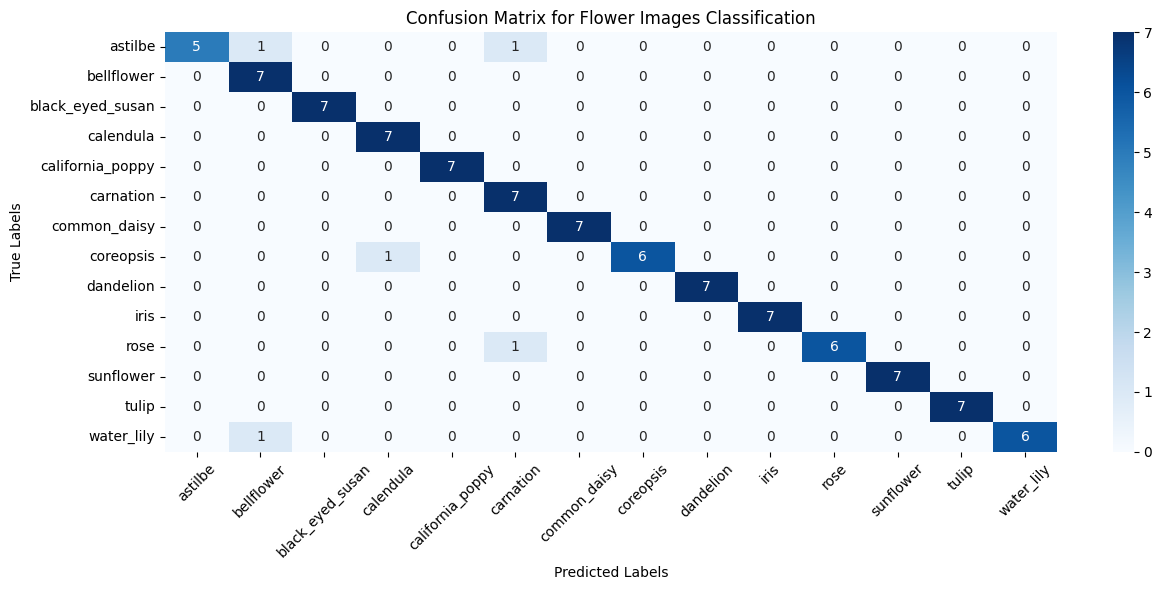

In [ ]:
conf_matrix = confusion_matrix(labels, preds, labels=np.arange(num_classes))

plt.figure(figsize=(13, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.xticks(rotation=45)
plt.title("Confusion Matrix for Flower Images Classification")
plt.tight_layout()
plt.show()

This heatmap shows exactly how many images from each "True Label" class were predicted as each "Predicted Label" class. The strong diagonal line indicates accurate predictions, and any numbers off the diagonal show misclassifications.

## Visualizing Sample Predictions

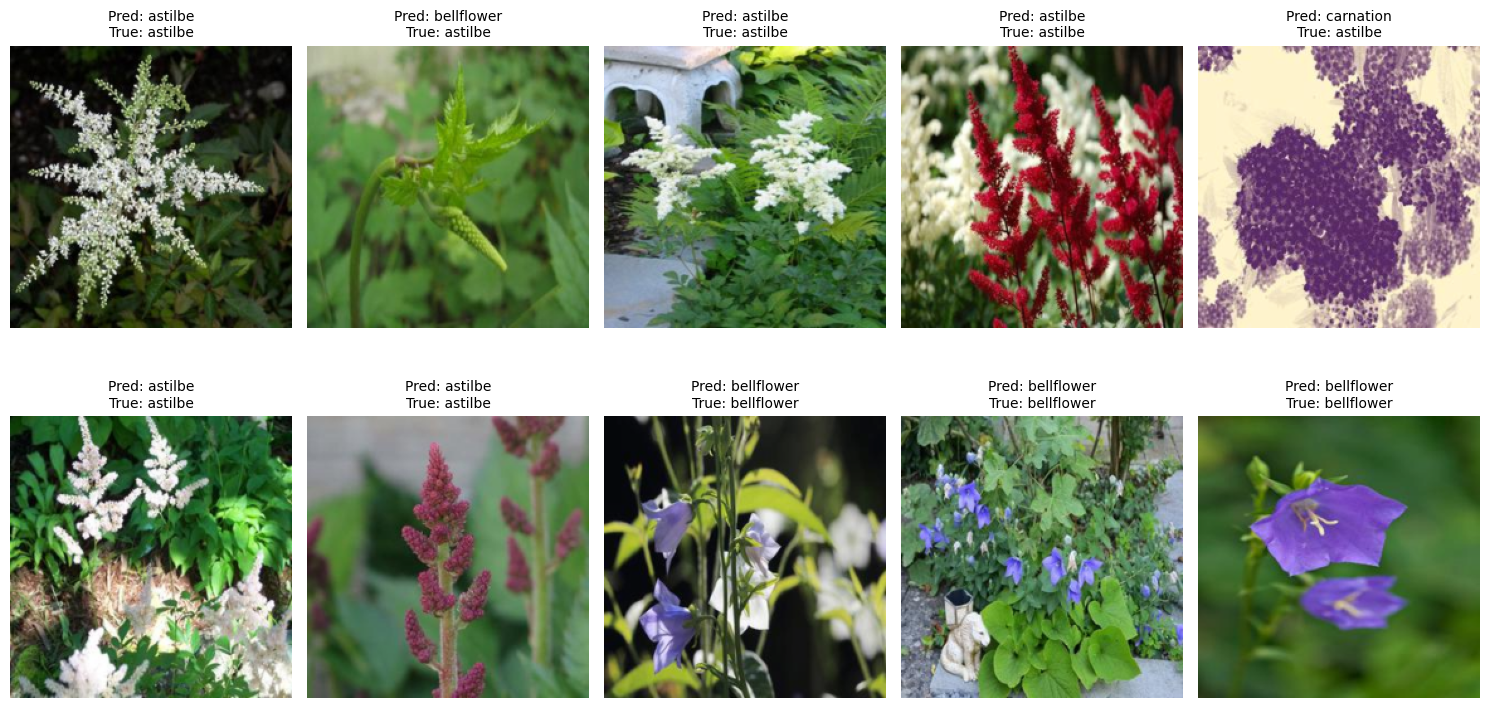

In [ ]:
# Function to unnormalize and show images
def imshow(img, title=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet stats
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title, fontsize=10)
    plt.axis('off')

# Get a batch of test images and predictions
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Show 8–10 images
num_images = 10
plt.figure(figsize=(15, 8))
for i in range(num_images):
    ax = plt.subplot(2, 5, i+1)
    title = f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}"
    imshow(images[i], title=title)
plt.tight_layout()
plt.show()


And lastly, we have a visual display of actual flower images with their true labels and predicted labels.